# Posterior Predictive Analysis for GARCH(1,1) Model

-  Step 1: Simulate hypothetical parameters via from posterior distribution via HMC in Stan

- Step 2: Compute simulated data via the likelihood function, conditional on the simulated parameters (in Stan)

- Step 3: Compare simulated data with observed data to validate model

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print("Current working directory: ", os.getcwd())

Current working directory:  c:\Users\nklatsky\econometrics\econometrics2024\project\code\garch


## Read in Real Data

In [3]:
# Read in the train-test split 
# Read train_test.csv
train_test_split = pd.read_csv("../../train_test.csv")
train_size = train_test_split['train'][0]
test_size = train_test_split['test'][0]

# Define data path:
data_path = "../../data/DXY_approx_percent_returns.csv"
real_data = pd.read_csv(data_path, index_col=0)
real_data = real_data - np.mean(real_data)

# calculate the splitting point as the train_size * len of data, rounded
split_point = int(train_size * len(real_data))

# Take training data range only
real_data = real_data.iloc[:split_point]
real_data


,DXY
Date,
1994-04-01,-0.435009
1994-05-01,0.030122
1994-06-01,0.247245
1994-07-01,-0.768186
1994-10-01,0.362673
...,...
2018-02-21,0.315110
2018-02-22,-0.294709
2018-02-23,0.162735


In [4]:
# calculate summary stats on real data: mean, std, skew, kurtosis, min, max, .025, .50, .975 quantiles
summary_stats = real_data.describe(percentiles=[.025, .5, .975])
summary_stats


,DXY
count,6241.000000
mean,-0.002077
std,0.498790
min,-3.057377
2.5%,-1.026845
50%,-0.000945
97.5%,1.018463
max,2.518960


## Read in Generated Data

In [5]:
# Read in generated data from prior predictive distribution(y_sim_samples)

garch_y_post_path = "sampler_outputs/y_post_samples.csv"
garch_y_post = pd.read_csv(garch_y_post_path)
garch_y_post

,0,1,2,3,4,5,6,7,8,9,...,6231,6232,6233,6234,6235,6236,6237,6238,6239,6240
0,-0.420741,0.174848,-0.643600,-1.118980,0.306259,-1.255060,1.304810,-1.361100,0.779769,-0.271446,...,-0.075305,-0.468756,-0.186003,0.839865,-0.571641,0.102534,0.593099,-0.167591,-0.094046,-0.144810
1,-1.278540,-0.446584,-0.384018,1.535160,1.267770,1.303310,0.521350,0.074429,0.276491,-0.448497,...,0.102981,0.404827,-0.151557,0.651238,0.016717,-0.203475,0.031820,-0.146387,-0.789435,0.152677
2,-0.030724,0.266034,-0.013488,1.082060,0.079675,-0.364387,-0.640222,0.322407,-0.706881,-0.291707,...,-0.159546,0.164124,-0.458903,-0.469962,0.054821,0.057795,1.049780,0.587783,-0.449959,-0.484510
3,-1.157890,0.430240,0.693121,-0.753075,-0.304563,-1.034980,0.796196,1.274190,0.776082,0.640927,...,1.328080,0.023534,-0.816898,1.234330,0.266902,-0.615279,-0.109973,-0.361060,0.316178,-0.507824
4,-1.638500,1.294120,-0.456230,2.104110,-1.082430,0.251768,0.115762,0.129854,0.327845,-0.638070,...,-0.601752,-0.366812,0.383974,0.056491,-0.198051,0.463591,0.329588,-0.034126,-0.256411,0.586040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-0.193079,-0.258641,0.914001,-0.391675,1.165690,0.617744,-1.686400,0.741345,0.189243,0.176766,...,0.186291,0.278026,-0.539118,-0.187415,-0.752938,-0.314775,0.046228,-0.105080,0.406741,0.169359
3996,0.172766,0.192161,0.792760,0.332397,0.184702,-0.172584,0.592108,0.713694,-0.145864,-0.041698,...,-0.237856,-0.333770,0.226511,0.308651,-0.164146,0.353825,0.394480,0.590171,-0.368663,-1.151270
3997,0.484308,1.433520,0.109494,-0.912851,-0.019555,0.304697,-0.420176,-0.115997,-0.013865,0.498660,...,-0.351172,0.553033,0.135577,-0.099345,-0.082757,-0.569868,0.592530,-0.416919,-0.314426,0.205730
3998,-0.477549,0.069136,1.502280,1.328990,0.149266,-0.125066,0.119174,-0.033621,-0.329433,0.275707,...,0.118180,0.976818,-0.139010,0.442856,-0.148663,0.658512,-0.207694,1.232770,-0.753234,-0.885266


# Comparison

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Selecting indices for detailed comparison, assuming a larger dataset
indices = [5, 2000, 3000]

# Loop through selected indices
for index in indices:
    real_sample = real_data
    post_sample = garch_y_post.iloc[index]

    # Calculate statistics for the current index
    real_mean = np.mean(real_sample)
    real_std = np.std(real_sample)
    real_skew = real_sample.skew()
    real_kurt = real_sample.kurt()

    post_mean = np.mean(post_sample)
    post_std = np.std(post_sample)
    post_skew = post_sample.skew()
    post_kurt = post_sample.kurt()

    # Print statistics
    print(f"Statistics for Index {index}:")
    print("Real Data Mean: ", real_mean)
    print("Posterior Data Mean: ", post_mean)
    print("Real Data StdDev: ", real_std)
    print("Posterior Data StdDev: ", post_std)
    print("Real Data Skewness: ", real_skew)
    print("Posterior Data Skewness: ", post_skew)
    print("Real Data Kurtosis: ", real_kurt)
    print("Posterior Data Kurtosis: ", post_kurt)
    print("\n")


Statistics for Index 5:
Real Data Mean:  -0.002077034927474549
Posterior Data Mean:  0.0022192251331517392
Real Data StdDev:  DXY    0.49875
dtype: float64
Posterior Data StdDev:  0.4916935197727773
Real Data Skewness:  DXY   -0.128806
dtype: float64
Posterior Data Skewness:  0.10240377557128055
Real Data Kurtosis:  DXY    1.943165
dtype: float64
Posterior Data Kurtosis:  0.5188692536058084


Statistics for Index 2000:
Real Data Mean:  -0.002077034927474549
Posterior Data Mean:  -0.0032579141011055924
Real Data StdDev:  DXY    0.49875
dtype: float64
Posterior Data StdDev:  0.5120820428842822
Real Data Skewness:  DXY   -0.128806
dtype: float64
Posterior Data Skewness:  0.039351676342331866
Real Data Kurtosis:  DXY    1.943165
dtype: float64
Posterior Data Kurtosis:  0.7145906353548024


Statistics for Index 3000:
Real Data Mean:  -0.002077034927474549
Posterior Data Mean:  0.00019302033776638283
Real Data StdDev:  DXY    0.49875
dtype: float64
Posterior Data StdDev:  0.5015703133782853


c:\Users\nklatsky\econometrics\econometrics2024\myenv\Lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


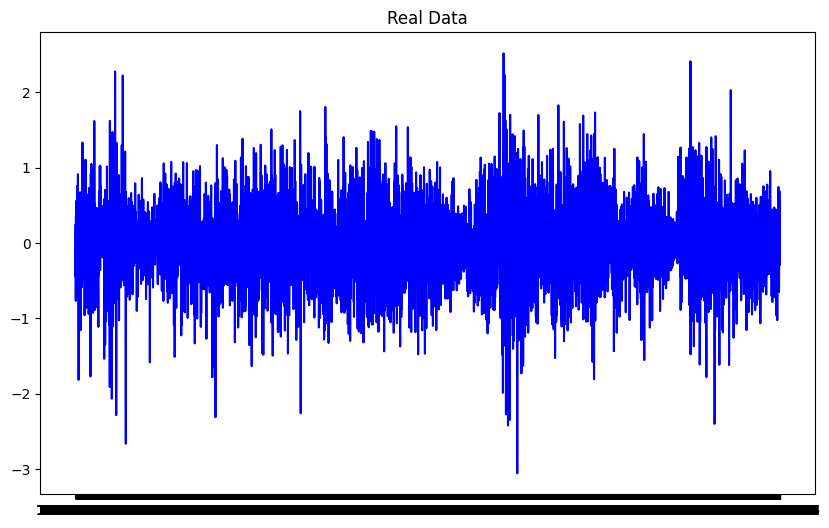

In [7]:
# Plot the real data as a time series
plt.figure(figsize=(10, 6))
plt.plot(real_data, color='blue')
plt.title("Real Data")
plt.show()


In [8]:
garch_y_post.iloc[500]
# real_data.iloc[:,0]

0      -1.518770
1      -0.632669
2      -1.708020
3       0.708039
4      -1.275410
          ...   
6236    0.119295
6237    0.233161
6238   -0.314478
6239   -0.420248
6240   -0.387166
Name: 500, Length: 6241, dtype: float64

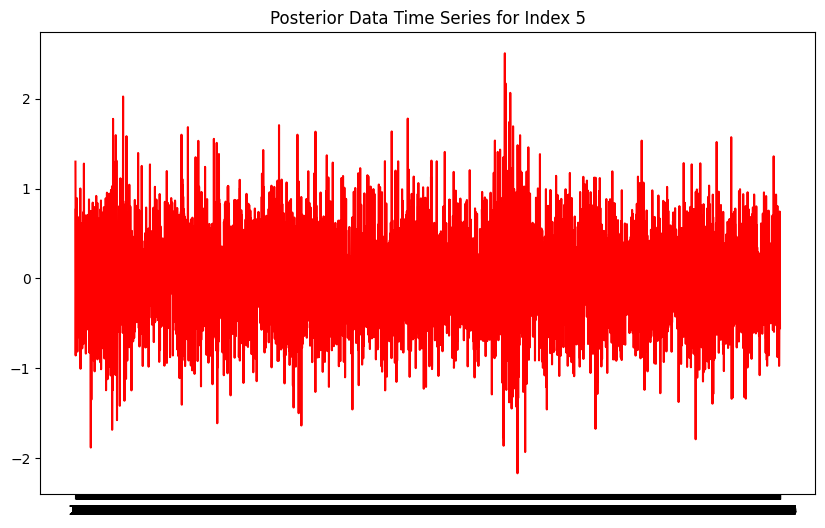

In [9]:
# Plot the posterior data for 3 random indices as a time series
indices = [5]

for index in indices:
    post_sample = garch_y_post.iloc[index]

    plt.figure(figsize=(10, 6))
    plt.plot(post_sample, color='red')
    plt.title(f"Posterior Data Time Series for Index {index}")
    plt.show()
    

Statistics for Index 5:
Real Data Mean:  DXY   -0.002077
dtype: float64
Posterior Data Mean:  0.0022192251331517392
Real Data StdDev:  DXY    0.49879
dtype: float64
Posterior Data StdDev:  0.49173291671365005
Real Data Skewness:  DXY   -0.128806
dtype: float64
Posterior Data Skewness:  0.10240377557128055
Real Data Kurtosis:  DXY    1.943165
dtype: float64
Posterior Data Kurtosis:  0.5188692536058084




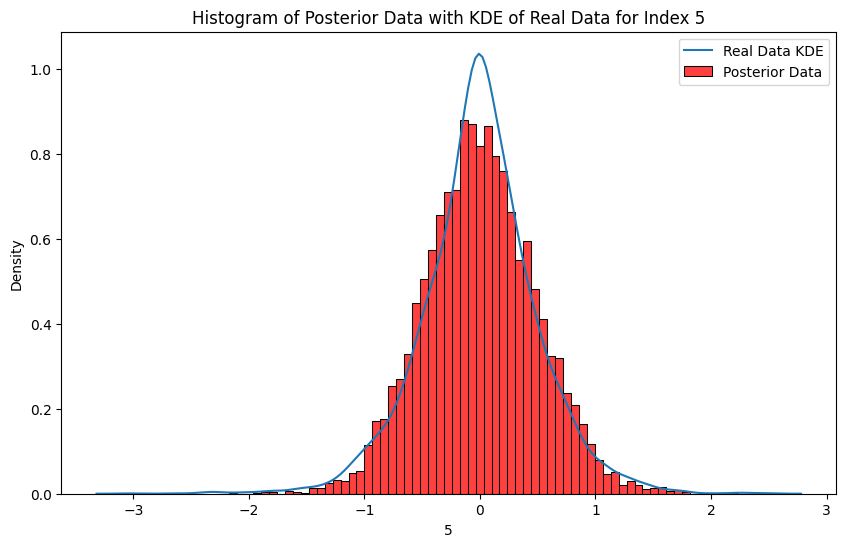

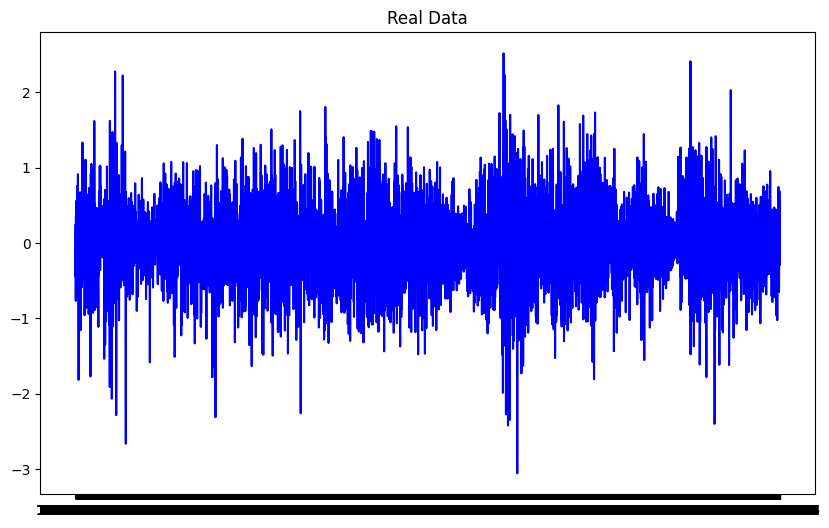

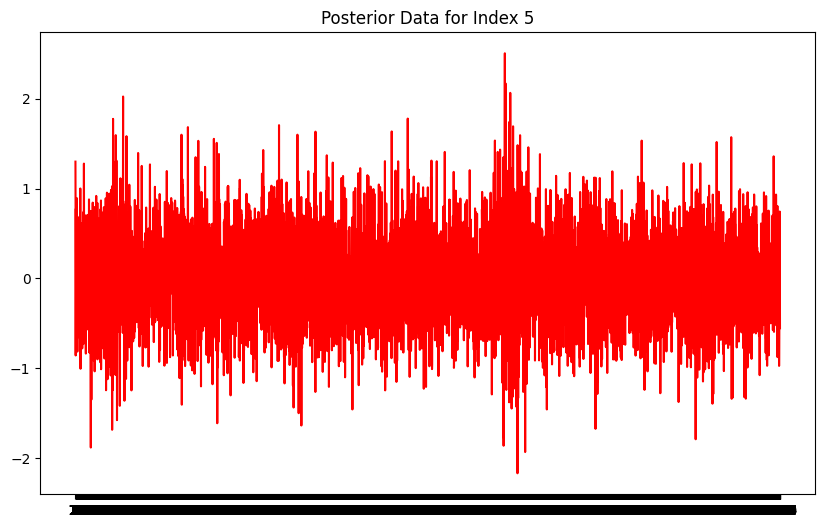

Statistics for Index 3000:
Real Data Mean:  DXY   -0.002077
dtype: float64
Posterior Data Mean:  0.00019302033776638283
Real Data StdDev:  DXY    0.49879
dtype: float64
Posterior Data StdDev:  0.5016105016971975
Real Data Skewness:  DXY   -0.128806
dtype: float64
Posterior Data Skewness:  0.04359693795134151
Real Data Kurtosis:  DXY    1.943165
dtype: float64
Posterior Data Kurtosis:  0.3562808819020309




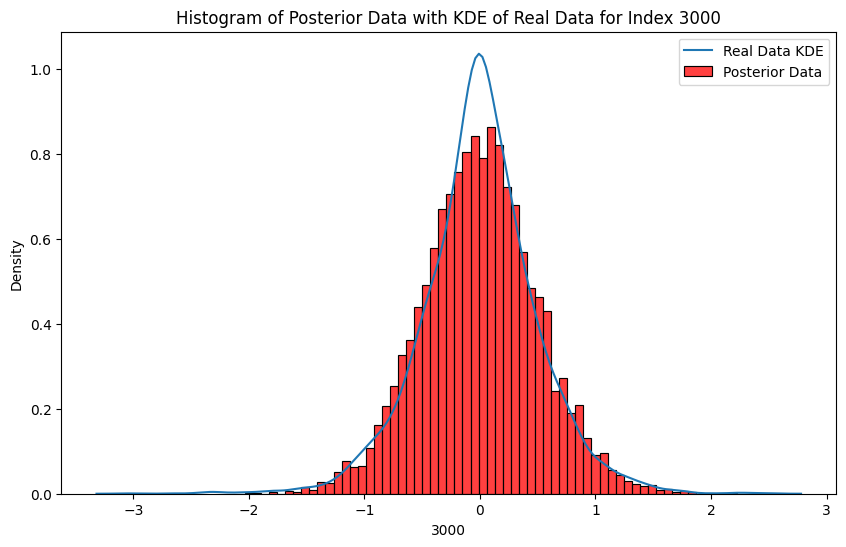

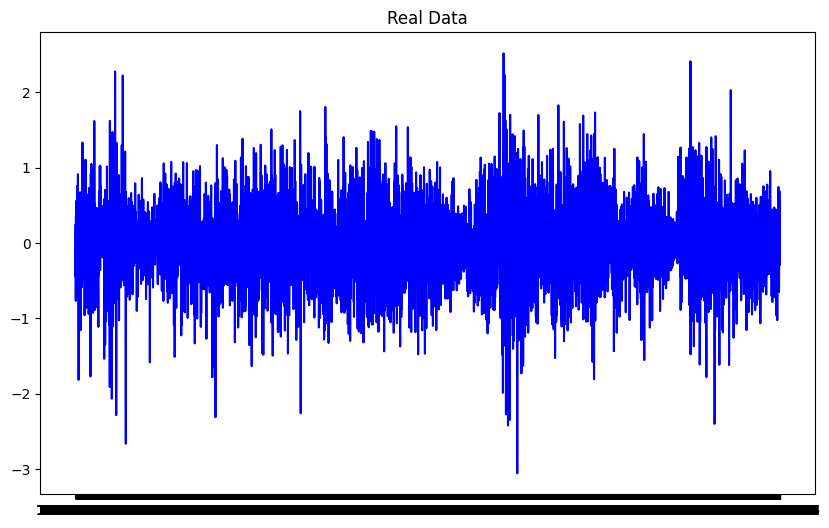

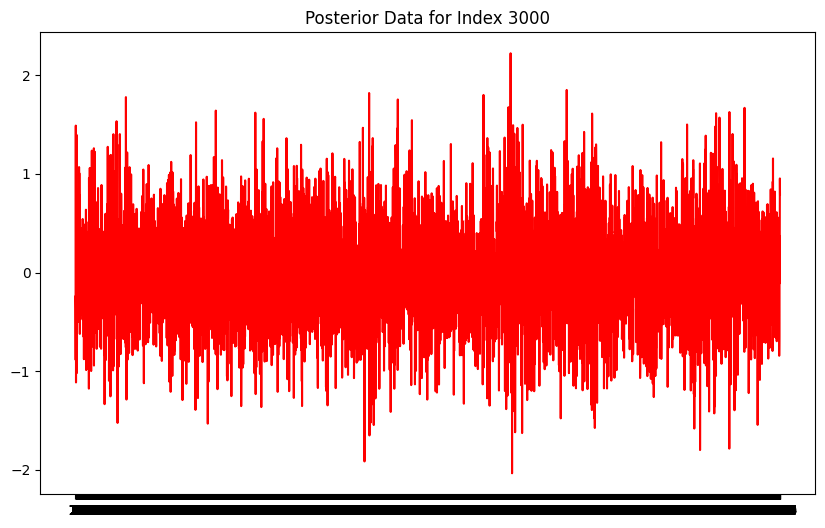

In [10]:
indices = [5, 3000]

for index in indices:
    real_sample = real_data
    post_sample = garch_y_post.iloc[index]

    # Compute statistics
    real_mean = real_sample.mean()
    real_std = real_sample.std()
    real_skew = real_sample.skew()
    real_kurt = real_sample.kurt()

    post_mean = post_sample.mean()
    post_std = post_sample.std()
    post_skew = post_sample.skew()
    post_kurt = post_sample.kurt()

    # Print statistics
    print(f"Statistics for Index {index}:")
    print("Real Data Mean: ", real_mean)
    print("Posterior Data Mean: ", post_mean)
    print("Real Data StdDev: ", real_std)
    print("Posterior Data StdDev: ", post_std)
    print("Real Data Skewness: ", real_skew)
    print("Posterior Data Skewness: ", post_skew)
    print("Real Data Kurtosis: ", real_kurt)
    print("Posterior Data Kurtosis: ", post_kurt)
    print("\n")

    # Plot histograms with KDE for real datasets overlaid
    plt.figure(figsize=(10, 6))
    sns.histplot(post_sample, kde=False, color='red', label='Posterior Data', stat="density")
    sns.kdeplot(real_sample, color='blue', label='Real Data KDE')
    plt.title(f"Histogram of Posterior Data with KDE of Real Data for Index {index}")
    plt.legend()
    plt.show()

    # Plot time series data
    plt.figure(figsize=(10, 6))
    plt.plot(real_sample, color='blue', label='Real Data')
    plt.title("Real Data")
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(post_sample, color='red', label='Posterior Data')
    plt.title(f"Posterior Data for Index {index}")
    plt.show()